In [0]:


! pip3 install gym
! pip3 install torch

import gym
import torch
import torch.nn as nn
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pdb



In [0]:
def calculate_return(memory, rollout, gamma):
  """Return memory with calculated return in experience tuple

    Args:
        memory (list): (state, action, action_dist, return) tuples
        rollout (list): (state, action, action_dist, reward) tuples from last rollout
        gamma (float): discount factor

    Returns:
        list: memory updated with (state, action, action_dist, return) tuples from rollout
  for s,a,a_dist,reward in reversed(rollout):
    r = r + discounted
    discounted += gamma * r
    memory.extend(rollout)
  """
  ret=0
  for s,a,a_dist,r in reversed(rollout):
    ret = r+ret*gamma
    memory.append((s,a,a_dist,ret))

  #pdb.set_trace()
  return memory


def get_action_ppo(network, state):
  """Sample action from the distribution obtained from the policy network

    Args:
        network (PolicyNetwork): Policy Network
        state (np-array): current state, size (state_size)

    Returns:
        int: action sampled from output distribution of policy network
        array: output distribution of policy network
  """
  #pdb.set_trace()
  temp=torch.tensor(np.float32(state)).unsqueeze(0).cuda()
  a_dist = network(temp)
  action = torch.multinomial(a_dist,1).squeeze(0).squeeze(0)
  return action, a_dist.detach()

  

def learn_ppo(optim, policy, value, memory_dataloader, epsilon, policy_epochs):
  """Implement PPO policy and value network updates. Iterate over your entire 
     memory the number of times indicated by policy_epochs.    

    Args:
        optim (Adam): value and policy optimizer
        policy (PolicyNetwork): Policy Network
        value (ValueNetwork): Value Network
        memory_dataloader (DataLoader): dataloader with (state, action, action_dist, return, discounted_sum_rew) tensors
        epsilon (float): trust region
        policy_epochs (int): number of times to iterate over all memory
  """
  i=0
  vloss=0
  for _ in range(policy_epochs):
    for state,action,action_dist,ret in memory_dataloader:
      state=state.float()
      value_out = value(state.cuda())
      vloss=(torch.sum((ret-value_out.cpu())**2))/ret.size(0)
      batch_size=len(state)
      

      action_oh=torch.FloatTensor(batch_size,2)*0#create a batch size by 2 matrix
      action_out=action_oh.scatter(1,action.long().cpu().unsqueeze(1),1)#create a onehot matrix from which actions are tkane
      old_prob=torch.gather(action_dist.squeeze(1),1,action.long().unsqueeze(1).cuda())
      #cur_prob = policy(state.cuda())
      
      policy_out = policy(state.cuda())
      cur_prob=torch.gather(policy_out,1,action.long().unsqueeze(1).cuda())
      ratio = cur_prob/old_prob
      
      advantage = ret - value_out.squeeze(1).cpu()
      advantage = advantage.detach()

      left=ratio.cpu().squeeze(1) *advantage
      temp=torch.clamp(ratio,1-epsilon,1+epsilon).squeeze(1)
      right = temp.cpu() * advantage.cpu().detach()
      p_loss = -torch.mean(torch.min(left,right))

      loss = p_loss+vloss
      loss = loss.unsqueeze(0)
      optim.zero_grad()
      loss.backward()
      optim.step()

  return loss



In [0]:
# Dataset that wraps memory for a dataloader
class RLDataset(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = []
    for d in data:
      self.data.append(d)
  
  def __getitem__(self, index):
    return self.data[index]
 
  def __len__(self):
    return len(self.data)


# Policy Network
class PolicyNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8
    
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size),
                             nn.Softmax(dim=1))
  
  def forward(self, x):
    """Get policy from state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          action_dist (tensor): probability distribution over actions (batch x action_size)
    """
    return self.net(x)
  

# Value Network
class ValueNetwork(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    hidden_size = 8
  
    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, 1))
    
  def forward(self, x):
    """Estimate value given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          value (tensor): estimated value, size (batch)
    """
    return self.net(x)

Epochs: 19 Reward: 200.0: 100%|██████████| 20/20 [01:58<00:00,  9.67s/it]

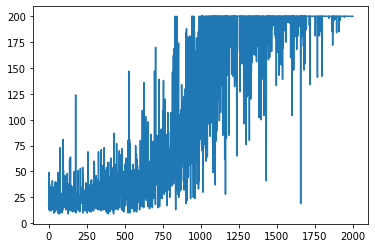

In [0]:


def ppo_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 20
  env_samples = 100
  gamma = 0.9
  batch_size = 256
  epsilon = 0.2
  policy_epochs = 5

  # Init environment 
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1')

  # Init networks
  policy_network = PolicyNetwork(state_size, action_size).cuda()
  value_network = ValueNetwork(state_size).cuda()

  # Init optimizer
  optim = torch.optim.Adam(chain(policy_network.parameters(), value_network.parameters()), lr=lr)

  # Start main loop
  results_ppo = []
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    
    memory = []  # Reset memory every epoch
    rewards = []  # Calculate average episodic reward per epoch

    # Begin experience loop
    for episode in range(env_samples):
      
      # Reset environment
      state = env.reset()
      done = False
      rollout = []
      cum_reward = 0  # Track cumulative reward

      # Begin episode
      while not done and cum_reward < 200:  # End after 200 steps   
        # Get action
        #pdb.set_trace()
        action, action_dist = get_action_ppo(policy_network, state)
        #pdb.set_trace()
        # Take step
        next_state, reward, done, _ = env.step(action.cpu().item())
        # env.render()

        # Store step
        rollout.append((state, action, action_dist, reward))

        cum_reward += reward
        state = next_state  # Set current state

      # Calculate returns and add episode to memory
      memory = calculate_return(memory, rollout, gamma)

      rewards.append(cum_reward)
      
    # Train
    dataset = RLDataset(memory)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    learn_ppo(optim, policy_network, value_network, loader, epsilon, policy_epochs)
    
    # Print results
    results_ppo.extend(rewards)  # Store rewards for this epoch
    loop.update(1)

    loop.set_description("Epochs: {} Reward: {}".format(epoch, results_ppo[-1]))

  return results_ppo

results_ppo = ppo_main()


plt.plot(results_ppo)
plt.show()


